LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [1/100], Loss: 0.0282, Time: 0.29s
Epoch [11/100], Loss: 0.0002, Time: 0.28s
Epoch [21/100], Loss: 0.0001, Time: 0.23s
Epoch [31/100], Loss: 0.0001, Time: 0.23s
Epoch [41/100], Loss: 0.0001, Time: 0.24s
Epoch [51/100], Loss: 0.0001, Time: 0.24s
Epoch [61/100], Loss: 0.0001, Time: 0.78s
Epoch [71/100], Loss: 0.0001, Time: 0.59s
Epoch [81/100], Loss: 0.0001, Time: 0.72s
Epoch [91/100], Loss: 0.0001, Time: 0.32s
Normalized RMSE: 2556.7141


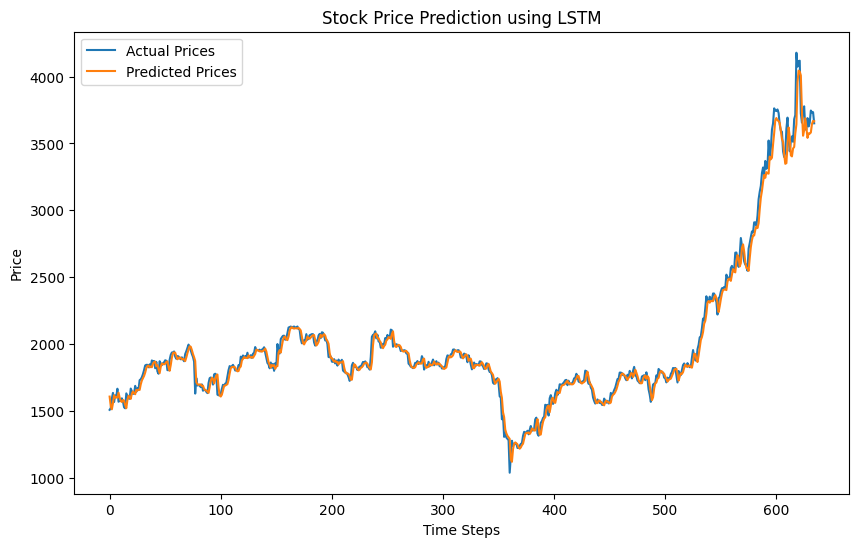

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import time

# Step 1: Load CSV and preprocess
data = pd.read_csv("ADANIPORTS.csv")
series = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Step 2: Split data into training and testing
train_size = int(len(series_scaled) * 0.8)
train_data, test_data = series_scaled[:train_size], series_scaled[train_size:]

# Step 3: Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

seq_length = 30
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Step 4: DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Step 5: Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#batch first=true is for easy formatting
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Use the output from the last time step
#the output of the LSTM at the last time step is passed through a fully connected layer (self.fc) for further processing
# , such as making a prediction based on the final sequence state.   
        return output

input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 1
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
print(model)

# Step 6: Initialize loss and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train function
def train_model(model, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')

# Step 8: Train the LSTM model
train_model(model, train_loader, num_epochs=100)

# Step 9: Make predictions
model.eval()
with torch.no_grad():
    test_inputs = x_test
    predictions = model(test_inputs)

# Step 10: Inverse transform and plot
prediction_t = scaler.inverse_transform(predictions.detach().numpy())
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
rmse = np.sqrt(mean_squared_error(y_test_np, prediction_t))
normalized_rmse = rmse / (np.max(y_test_np) - np.min(y_test_np))

print(f'RMSE: {normalized_rmse:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices')
plt.plot(prediction_t, label='Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()


In [ ]:
#calculating no.of parameters
input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 1
total=(4*hidden_dim*(hidden_dim+input_dim+1))+(hidden_dim*output_dim)+output_dim
print(f"no.of parameters LSTM use:{total}")

no.of parameters LSTM use:16961
